In [1]:
import glob
import numpy as np
import pandas as pd
import scipy.io as spio
from natsort import natsorted
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.ndimage.filters import gaussian_filter1d
import warnings
warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D


Bad key savefig.frameon in file /home/rajat/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/rajat/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/rajat/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need to get an upd

In [2]:
def getRatemap(hnum):
    rmaps = []
    files = natsorted(glob.glob('ClustId*_hall'+str(hnum)+'_processed.mat'))
    for j, filename in enumerate(files):
        data = spio.loadmat(filename)
        rmap = data['smoothratemaptrial']
        rmaps.append(rmap)
    rmaps = np.array(rmaps)
    rmaps = np.moveaxis(rmaps, [0,1,2], [-2,-3,-1])
    return rmaps

def add_orientation_legend(ax):
    custom_lines = [Line2D([0], [0], color=pal[k], lw=4) for
                    k in range(len(trial_types))]
    labels = ['Hall {}'.format(t) for t in trial_types]
    ax.legend(custom_lines, labels,
              frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout(rect=[0,0,0.9,1])

In [3]:
# load cluster information
cluster_info = pd.read_csv('cluster_info.tsv',delimiter='\t')
cluster_id = np.array(cluster_info['id'])
# load cluster quality data and final sorted cluster amplitude and firing rate
good_clusters_id = cluster_id[np.where(cluster_info['group']=='good')[0]]
del cluster_info

In [4]:
rmaps_h1 = getRatemap(1)
rmaps_h2 = getRatemap(2)
rmaps_h3 = getRatemap(3)
rmaps_h4 = getRatemap(4)

trialtype_h1 = np.array([1]*rmaps_h1.shape[0])
trialtype_h2 = np.array([2]*rmaps_h2.shape[0])
trialtype_h3 = np.array([3]*rmaps_h3.shape[0])
trialtype_h4 = np.array([4]*rmaps_h4.shape[0])

# trials is a list of K Numpy arrays of shape N×T (number of neurons by number of time points).
trials = np.concatenate((rmaps_h1, rmaps_h2, rmaps_h3, rmaps_h4))
# trial_type is a list of length K containing the type (i.e. the orientation) of every trial.
trial_type = np.concatenate((trialtype_h1, trialtype_h2, trialtype_h3, trialtype_h4))
# trial_types is a list containing the unique trial types (i.e. orientations) in ascending order.
trial_types = [1, 2, 3, 4]

del rmaps_h1, rmaps_h2, rmaps_h3, rmaps_h4
del trialtype_h1, trialtype_h2, trialtype_h3, trialtype_h4

In [5]:
print('Number of trials: {}'.format(len(trials)))
print('Types of trials: {}'.format(trial_types)) 
print('Dimensions of single trial array (# neurons by # time points): {}'.format(trials[0].shape))
print('Trial types: {}'.format(trial_types))
print('Trial type of the first 3 trials: {}'.format(trial_type[0:3]))

Number of trials: 526
Types of trials: [1, 2, 3, 4]
Dimensions of single trial array (# neurons by # time points): (98, 24)
Trial types: [1, 2, 3, 4]
Trial type of the first 3 trials: [1 1 1]


In [6]:
t_type_ind = [np.argwhere(np.array(trial_type) == t_type)[:, 0] for t_type in trial_types]
trial_size   = trials[0].shape[1]
Nneurons     = trials[0].shape[0]

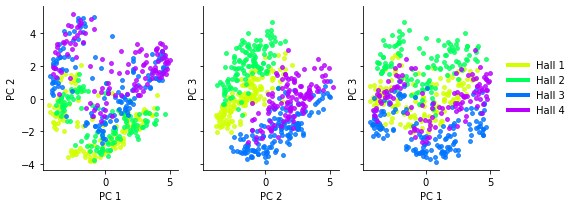

In [7]:
### Trial-response PCA
Xr = np.vstack([t.mean(axis=1) for t in trials]).T
Xr_sc = stats.zscore(Xr, nan_policy='omit')
Xr_sc[np.isnan(Xr_sc)] = 0

pca = PCA(n_components=20)
Xp = pca.fit_transform(Xr_sc.T).T

pal = sns.color_palette('hsv', 4)
projections = [(0, 1), (1, 2), (0, 2)]
fig, axes = plt.subplots(1, 3, figsize=[9, 3], sharey='row', sharex='row')
for ax, proj in zip(axes, projections):
    for t, t_type in enumerate(trial_types):
        x = Xp[proj[0], t_type_ind[t]]
        y = Xp[proj[1], t_type_ind[t]]
        ax.scatter(x, y, color=pal[t], s=15, alpha=0.8)
        ax.set_xlabel('PC {}'.format(proj[0]+1))
        ax.set_ylabel('PC {}'.format(proj[1]+1))
sns.despine(fig=fig, top=True, right=True)
add_orientation_legend(axes[2])

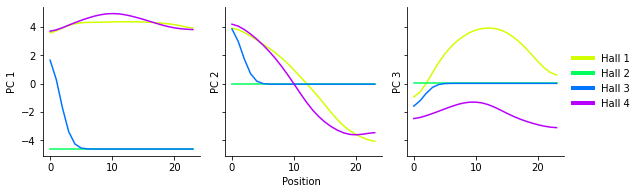

In [8]:
### Trial-averaged PCA
trial_averages = []
for ind in t_type_ind:
    trial_averages.append(np.array(trials)[ind].mean(axis=0))
Xa = np.hstack(trial_averages)
Xa = stats.zscore(Xa, nan_policy='omit') 
Xa[np.isnan(Xa)] = 0

pca = PCA(n_components=20)
Xa_p = pca.fit_transform(Xa.T).T

fig, axes = plt.subplots(1, 3, figsize=[10, 2.8], sharey='row')
for comp in range(3):
    ax = axes[comp]
    for kk, type in enumerate(trial_types):
        x = Xa_p[comp, kk * trial_size :(kk+1) * trial_size]
        x = gaussian_filter1d(x, sigma=1.5)
        ax.plot(x, c=pal[kk])
    ax.set_ylabel('PC {}'.format(comp+1))
add_orientation_legend(axes[2])
axes[1].set_xlabel('Position ')
sns.despine(fig=fig, right=True, top=True)
plt.tight_layout(rect=[0, 0, 0.9, 1])

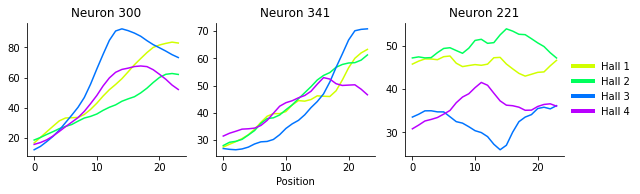

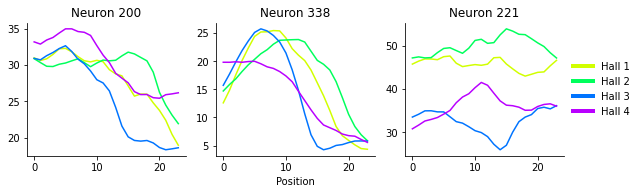

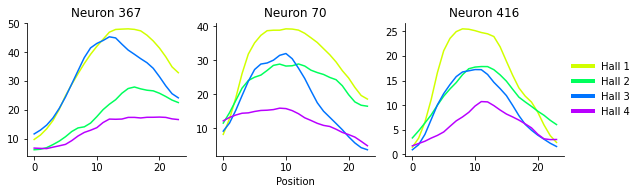

In [9]:
### Find the indices of the three largest elements of the first threee eigenvector
for e in range(3):
    units = np.abs(pca.components_[e, :].argsort())[::-1][0:3]
    f, axes = plt.subplots(1, 3, figsize=[10, 2.8], sharey=False,sharex=True)
    for ax, unit in zip(axes, units):
        ax.set_title('Neuron {}'.format(good_clusters_id[unit]))
        for t, ind in enumerate(t_type_ind):
            x = np.nanmean(np.array(trials)[ind][:, unit, :],0)
            ax.plot(np.arange(x.shape[0]), x, color=pal[t])
    #for ax in axes:
    #    ax.axvline(x=37, alpha=0.8, color='gray', ls='--')
    axes[1].set_xlabel('Position')
    sns.despine(fig=f, right=True, top=True)
    add_orientation_legend(axes[2])

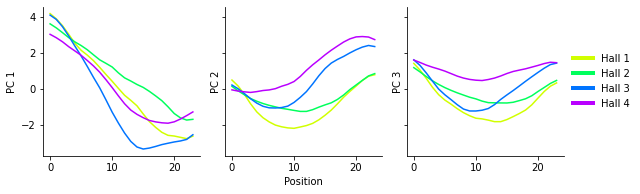

In [10]:
### Trial-concatented PCAs
Xl = np.hstack(trials)
Xl = stats.zscore(Xl, nan_policy='omit')
Xl[np.isnan(Xl)] = 0

pca = PCA(n_components=20)
Xl_p = pca.fit_transform(Xl.T).T

n_components = 20
gt = {comp : {t_type : [] for t_type in trial_types} for comp in range(n_components)}
for comp in range(n_components):
    for i, t_type in enumerate(trial_type):
        t = Xl_p[comp, trial_size * i: trial_size * (i + 1)]
        gt[comp][t_type].append(t)
for comp in range(n_components):
    for t_type in trial_types:
        gt[comp][t_type] = np.vstack(gt[comp][t_type])

f, axes = plt.subplots(1, 3, figsize=[10, 2.8], sharey=True, sharex=True)
for comp in range(3):
    ax = axes[comp]
    for t, t_type in enumerate(trial_types):
        ax.plot(np.nanmean(gt[comp][t_type],0), c=pal[t])
    #ax.axvline(x=37, alpha=0.8, color='gray', ls='--')
    ax.set_ylabel('PC {}'.format(comp+1))
axes[1].set_xlabel('Position')
sns.despine(right=True, top=True)
add_orientation_legend(axes[2])

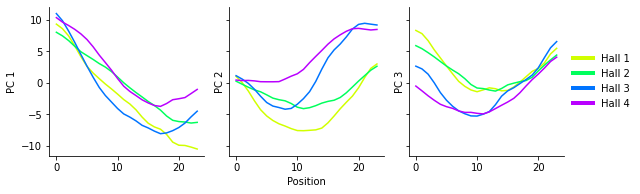

In [11]:
### average-concatenated PCAs
# fit PCA on trial averages
trial_averages = []
for ind in t_type_ind:
    trial_averages.append(np.array(trials)[ind].mean(axis=0))
Xav = np.hstack(trial_averages)

ss = StandardScaler(with_mean=True, with_std=True)
Xav_sc = ss.fit_transform(Xav.T).T
Xav_sc[np.isnan(Xav_sc)] = 0.
pca = PCA(n_components=20) 
pca.fit(Xav_sc.T) # only call the fit method

projected_trials = []
for trial in trials:
    # scale every trial using the same scaling applied to the averages 
    trial = ss.transform(trial.T).T
    trial[np.isnan(trial)]=0
    # project every trial using the pca fit on averages
    proj_trial = pca.transform(trial.T).T
    projected_trials.append(proj_trial)
    
gt = {comp: {t_type: [] for t_type in trial_types}
      for comp in range(n_components)}
for comp in range(n_components):
    for i, t_type in enumerate(trial_type):
        t = projected_trials[i][comp, :]
        gt[comp][t_type].append(t)

f, axes = plt.subplots(1, 3, figsize=[10, 2.8], sharey=True, sharex=True)
for comp in range(3):
    ax = axes[comp]
    for t, t_type in enumerate(trial_types):
        ax.plot(np.nanmean(gt[comp][t_type],0), color=pal[t])
    #ax.axvline(x=37, alpha=0.8, color='gray', ls='--')
    ax.set_ylabel('PC {}'.format(comp+1))
axes[1].set_xlabel('Position')
sns.despine(right=True, top=True)
add_orientation_legend(axes[2])

In [12]:
### Visualization
from matplotlib import animation 
from IPython.display import HTML

# smooth the single projected trials 
for i in range(len(projected_trials)):
    for c in range(projected_trials[0].shape[0]):
        projected_trials[i][c, :] = gaussian_filter1d(projected_trials[i][c, :], sigma=3)

# for every time point (imaging frame) get the position in PCA space of every trial
pca_frame = []
for t in range(trial_size):
    # projected data for all trials at time t 
    Xp = np.hstack([tr[:, None, t] for tr in projected_trials]).T
    pca_frame.append(Xp)
    
subspace = (1, 2) # pick the subspace given by the second and third components
# set up the figure
fig, ax = plt.subplots(1, 1, figsize=[6, 6]); plt.close()
ax.set_xlim(( -15, 15))
ax.set_ylim((-15, 15))
ax.set_xlabel('PC 2')
ax.set_xticks([-10, 0, 10])
ax.set_yticks([-10, 0, 10])
ax.set_ylabel('PC 3')
sns.despine(fig=fig, top=True, right=True)

# generate empty scatter plot to be filled by data at every time point
scatters = []
for t, t_type in enumerate(trial_types):
    scatter, = ax.plot([], [], 'o', lw=0.5, color=pal[t]);
    scatters.append(scatter)

# red dot to indicate when stimulus is being presented
stimdot, = ax.plot([], [], 'o', c='r', markersize=35, alpha=0.5)
# annotate with stimulus and time information
text     = ax.text(6.3, 8, 'Stimulus OFF \nt = {:.2f}'.format(0), fontdict={'fontsize':14})
time = np.arange(trials.shape[2])

# this is the function to be called at every animation frame
def animate(i):
    for t, t_type in enumerate(trial_types):
        # find the x and y position of all trials of a given type
        x = pca_frame[i][t_type_ind[t], subspace[0]]
        y = pca_frame[i][t_type_ind[t], subspace[1]]
        # update the scatter
        scatters[t].set_data(x, y)
        
        text.set_text('Stimulus ON \nt = {:.2f}'.format(time[i]))
        """if i>35 and i<40:
            stimdot.set_data(10, 14)
            text.set_text('Stimulus ON \nt = {:.2f}'.format(time[i]))
        else:
            stimdot.set_data([], [])
            text.set_text('Stimulus OFF \nt = {:.2f}'.format(time[i]))"""
    return (scatter,)

# generate the animation
anim = animation.FuncAnimation(fig, animate, frames=len(pca_frame), interval=120, blit=False)
HTML(anim.to_jshtml()) # render animation

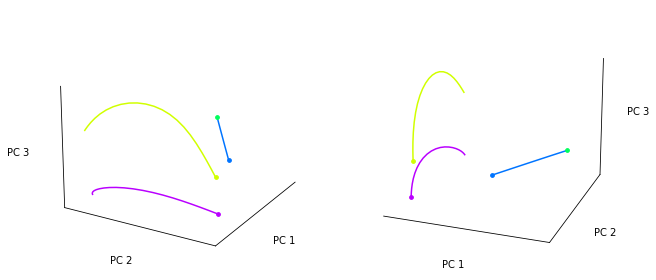

In [13]:
## 3D PCA trajectories
trial_averages = []
for ind in t_type_ind:
    trial_averages.append(np.array(trials)[ind].mean(axis=0))
Xa = np.hstack(trial_averages)

# standardize and apply PCA
Xa = stats.zscore(Xa) 
Xa[np.isnan(Xa)] = 0.

pca = PCA(n_components=20)
Xa_p = pca.fit_transform(Xa.T).T

# pick the components corresponding to the x, y, and z axes
component_x = 0
component_y = 1
component_z = 2

# create a boolean mask so we can plot activity during stimulus as 
# solid line, and pre and post stimulus as a dashed line
#stim_mask = ~np.concatenate(([False]*37,[True]*37))

# utility function to clean up and label the axes
def style_3d_ax(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')

sigma = 3 # smoothing amount

# set up a figure with two 3d subplots, so we can have two different views
fig = plt.figure(figsize=[9, 4])
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
axs = [ax1, ax2]
for ax in axs:
    for t, t_type in enumerate(trial_types):
        # for every trial type, select the part of the component
        # which corresponds to that trial type:
        x = Xa_p[component_x, t * trial_size :(t+1) * trial_size]
        y = Xa_p[component_y, t * trial_size :(t+1) * trial_size]
        z = Xa_p[component_z, t * trial_size :(t+1) * trial_size]
        # apply some smoothing to the trajectories
        x = gaussian_filter1d(x, sigma=sigma)
        y = gaussian_filter1d(y, sigma=sigma)
        z = gaussian_filter1d(z, sigma=sigma)
        # use the mask to plot stimulus and pre/post stimulus separately
        z_stim = z.copy()
        #z_stim[stim_mask] = np.nan
        #z_prepost = z.copy()
        #z_prepost[~stim_mask] = np.nan
        ax.plot(x, y, z_stim, color = pal[t])
        #ax.plot(x, y, z_prepost, color=pal[t], ls=':')
        # plot dots at initial point
        ax.scatter(x[0], y[0], z[0], color=pal[t], s=14)
        # make the axes a bit cleaner
        style_3d_ax(ax)
# specify the orientation of the 3d plot        
ax1.view_init(elev=22, azim=30)
ax2.view_init(elev=22, azim=110)
plt.tight_layout()

In [14]:
# apply some smoothing to the trajectories
for c in range(Xa_p.shape[0]):
    Xa_p[c, :] =  gaussian_filter1d(Xa_p[c, :], sigma=sigma)

# pick the components corresponding to the x, y, and z axes
component_x = 1
component_y = 2
component_z = 3


# create the figure
fig = plt.figure(figsize=[9, 9]); plt.close()
ax = fig.add_subplot(1, 1, 1, projection='3d')
#stim_mask = ~np.concatenate(([False]*37,[True]*37))

def animate(i):
    ax.clear() # clear up trajectories from previous iteration
    style_3d_ax(ax)
    ax.view_init(elev=22, azim=30)
    for t, t_type in enumerate(trial_types):    
        x = Xa_p[component_x, t * trial_size :(t+1) * trial_size]
        y = Xa_p[component_y, t * trial_size :(t+1) * trial_size]
        z = Xa_p[component_z, t * trial_size :(t+1) * trial_size]
        z_stim = z.copy()
        #z_stim[stim_mask] = np.nan
        #z_prepost = z.copy()
        #z_prepost[~stim_mask] = np.nan
        ax.plot(x[0:i], y[0:i], z_stim[0:i], color=pal[t])
        #ax.plot(x[0:i], y[0:i], z_prepost[0:i], color=pal[t], ls=':')
    ax.set_xlim(( -4, 4))
    ax.set_ylim((-4, 4))
    ax.set_zlim((-4, 4))
    return []

anim = animation.FuncAnimation(fig, animate,frames=len(pca_frame), interval=50, blit=True)
HTML(anim.to_jshtml(default_mode='once'))